This vignette demonstrates how to estimate spatial autocorrelation from residuals of multiple regression across the Western US ecoregion groups in the absence of any spatial sub-sampling

First, we will load the necessary packages to run the code

In [9]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
#
# Author: Lewis Kunik - University of Utah
# Contact: lewis.kunik@utah.edu
#

#%%
#########################################
# Load packages
#########################################

# File system packages
import os  # operating system library
import sys
import glob
from pathlib import Path
import copy

# numerical/data management packages
import numpy as np
import xarray as xr 
import pandas as pd

# shapefile/geospatial packages
import geopandas as gpd
from shapely.geometry import mapping
from shapely.geometry import Point

# Stats packages
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

# time and date packages
import time
from datetime import datetime as dt  # date time library
from datetime import timedelta

# Standard plotting packages
from matplotlib import pyplot as plt  # primary plotting module
from matplotlib.ticker import FuncFormatter as FFmt  # need this for formatting plot ticks
import matplotlib.colors as mcolors

# Geospatial plotting packages
import cartopy.crs as ccrs  # cartopy is the best spatial plotting library i know
from cartopy.io import img_tiles  # cartopy's implementation of webtiles
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature




Define any global filepaths and variables that will be needed throughout the script 

In [ ]:

#########################################
# Define Global Filepaths
#########################################

dat_basedir = '/uufs/chpc.utah.edu/common/home/lin-group19/ltk/SIF/SIF_IAV/data/'
dat_dir_precip = '/uufs/chpc.utah.edu/common/home/lin-group19/ltk/SIF/SIF_IAV/data/TOT_WY_Precip'
EPA_ecoregion_dir = '/uufs/chpc.utah.edu/common/home/lin-group23/ltk/EPA/ecoregions/'
EPA_ecoregion_L3_file = os.path.join(EPA_ecoregion_dir, 'L3', 'WUS_cec_eco_l3.shp')
NLCD_dir = '/uufs/chpc.utah.edu/common/home/lin-group23/ltk/NLCD/'
elev_dir = '/uufs/chpc.utah.edu/common/home/lin-group23/ltk/SRTM/WUS/'
MAP_dir = '/uufs/chpc.utah.edu/common/home/lin-group23/ltk/GRIDMET/Precip/05d_1980-2010_mean/'

TCC_file = os.path.join(NLCD_dir, 'TreeCover/2019/NLCD_TCC_05d_WUS_2019.nc')
EPA_ecoregion_L3_file = os.path.join(EPA_ecoregion_dir, 'L3', 'WUS_cec_eco_l3.shp')
elev_file = os.path.join(elev_dir, 'SRTM_DEM_05d_WUS.nc')
MAP_file = os.path.join(MAP_dir, 'GRIDMET_TotalWYPrecip_WUS_1980-2010_mean.nc')

########################################
# Define Global Variables and constants
#########################################

# Define the averaging window definition for "annual" values
timing_label = 'FULL_YEAR' # options: "FULL_YEAR", "TOP_QUARTILE", "POST_PEAK_LAI", "PRE_PEAK_LAI"
dat_dir = os.path.join(dat_basedir, timing_label)  # directory where data files are stored, based on timing_label
analysis_years = range(2018, 2024)

## Define paths to data files
TROPOMI_SIF_file = glob.glob(f'{dat_dir}/TROPOMI_SIF*.nc')[0]

MODIS_NDVI_file = glob.glob(f'{dat_dir}/MODIS_MOD13A2_NDVI*.nc')[0]
MODIS_EVI_file = glob.glob(f'{dat_dir}/MODIS_MOD13A2_EVI*.nc')[0]
MODIS_NDMI_file = glob.glob(f'{dat_dir}/MODIS_MCD43A4_NDMI*.nc')[0]
MODIS_NIRv_file = glob.glob(f'{dat_dir}/MODIS_MCD43A4_NIRv*.nc')[0]
MODIS_LAI_file = glob.glob(f'{dat_dir}/MODIS_MOD15A2H_LAI*.nc')[0]
MODIS_LST_file = glob.glob(f'{dat_dir}/MODIS_MYD21A2_LST*.nc')[0]
GRIDMET_PDSI_file = glob.glob(f'{dat_dir}/GRIDMET_PDSI*.nc')[0]
GRIDMET_Tmax_file = glob.glob(f'{dat_dir}/GRIDMET_Tmax*.nc')[0]
GRIDMET_Tmin_file = glob.glob(f'{dat_dir}/GRIDMET_Tmin*.nc')[0]
GRIDMET_VPD_file = glob.glob(f'{dat_dir}/GRIDMET_VPD*.nc')[0]
GRIDMET_Precip_file = glob.glob(f'{dat_dir_precip}/GRIDMET_TotWYPrecip*.nc')[0]
TerraClimate_CWD_file = glob.glob(f'{dat_dir}/TerraClimate_CWD*.nc')[0]
TerraClimate_SoilM_file = glob.glob(f'{dat_dir}/TerraClimate_SoilM*.nc')[0]
nClimGrid_SPEI_01_file = glob.glob(f'{dat_dir}/nClimGrid_SPEI_01*.nc')[0]
nClimGrid_SPEI_02_file = glob.glob(f'{dat_dir}/nClimGrid_SPEI_02*.nc')[0]
nClimGrid_SPEI_03_file = glob.glob(f'{dat_dir}/nClimGrid_SPEI_03*.nc')[0]
nClimGrid_SPEI_06_file = glob.glob(f'{dat_dir}/nClimGrid_SPEI_06*.nc')[0]
nClimGrid_SPEI_09_file = glob.glob(f'{dat_dir}/nClimGrid_SPEI_09*.nc')[0]
nClimGrid_SPEI_12_file = glob.glob(f'{dat_dir}/nClimGrid_SPEI_12*.nc')[0]
nClimGrid_SPEI_24_file = glob.glob(f'{dat_dir}/nClimGrid_SPEI_24*.nc')[0]
nClimGrid_SPEI_36_file = glob.glob(f'{dat_dir}/nClimGrid_SPEI_36*.nc')[0]
nClimGrid_SPEI_48_file = glob.glob(f'{dat_dir}/nClimGrid_SPEI_48*.nc')[0]
nClimGrid_SPEI_60_file = glob.glob(f'{dat_dir}/nClimGrid_SPEI_60*.nc')[0]
nClimGrid_SPEI_72_file = glob.glob(f'{dat_dir}/nClimGrid_SPEI_72*.nc')[0]

#########################################
# Set plotting parameters
#########################################

plt.rcParams.update({
   'axes.labelsize': 16,
   'axes.titlesize': 16,
   'xtick.labelsize': 16,
   'ytick.labelsize': 15,
   'legend.fontsize': 13,
})

# use Google Satellite imagery as basemap
tiler = img_tiles.GoogleTiles(style='satellite')
crs = tiler.crs # set crs of map tiler
alpha = 0.8  # transparency 0-1
transform = ccrs.PlateCarree()  # transform specifies the crs that the data is in

tiler_zoom = 7  # define a zoom level of detail
extent = [-125.3, -102.7, 29.7, 50.3]  # [minx, maxx, miny, maxy], bounds for map

### Load state boundaries
fn = shpreader.natural_earth(
   resolution='10m', category='cultural', 
   name='admin_1_states_provinces',
)
reader = shpreader.Reader(fn)
states = [x for x in reader.records() if x.attributes["admin"] == "United States of America"] # get all states in US
states_geom = cfeature.ShapelyFeature([x.geometry for x in states], ccrs.PlateCarree())

# matplotlib map plotting functions
def z_axis_formatter(x, pos, deci=2):
   '''Format ticks to format with deci number of decimals'''

   return f'{x:.{deci}f}'



Define any functions that will be needed throughout the script

In [4]:
#########################################
# Define Global Functions
#########################################

# -----------------------------------------------------------------------
# Function to load xarray data and set CRS
# -----------------------------------------------------------------------
def load_xr(dat_xr_file, varname = None):
    if varname is not None:
        dat_xr = xr.open_dataset(dat_xr_file, decode_coords='all').sortby(['x', 'y'], ascending = True)[varname]
    else:
        dat_xr = xr.open_dataset(dat_xr_file, decode_coords='all').sortby(['x', 'y'], ascending = True)
    dat_xr.rio.write_crs(4326, inplace=True)
    return dat_xr


def xarray_to_long_df(da_dict, response_var_name):
    """
    Convert dictionary of xarray DataArrays to long format DataFrame
    suitable for mixed effects modeling
    """
    # Start with response variable - only keep essential coordinates
    response_da = da_dict[response_var_name]
    df = response_da.to_dataframe(name=response_var_name).reset_index()
    
    # Keep only the columns we need for merging and analysis
    essential_cols = ['x', 'y', response_var_name]
    if 'year' in df.columns:
        essential_cols.append('year')
    
    df = df[essential_cols].dropna(subset=[response_var_name])
    
    # Add explanatory variables one by one
    for var_name, da in da_dict.items():
        if var_name != response_var_name:
            # Convert to dataframe and keep only essential columns
            var_df = da.to_dataframe(name=var_name).reset_index()
            
            # Keep only coordinates and the variable of interest
            var_essential_cols = ['x', 'y', var_name]
            if 'year' in var_df.columns:
                var_essential_cols.append('year')
            
            var_df = var_df[var_essential_cols].dropna(subset=[var_name])
            
            # Handle time-invariant variables (no year dimension)
            if 'year' not in var_df.columns and 'year' in df.columns:
                # Replicate time-invariant data for each year
                years = df['year'].unique()
                var_df_expanded = []
                for year in years:
                    temp_df = var_df.copy()
                    temp_df['year'] = year
                    var_df_expanded.append(temp_df)
                var_df = pd.concat(var_df_expanded, ignore_index=True)
            
            # Determine merge columns
            merge_cols = ['x', 'y']
            if 'year' in var_df.columns:
                merge_cols.append('year')
                
            # Merge with main dataframe
            df = df.merge(var_df, on=merge_cols, how='inner')
    
    return df



# -----------------------------------------------------------------------
# Function to calculate empirical semivariogram
# -----------------------------------------------------------------------
def calculate_semivariogram(residuals, distances, n_bins=20, max_distance=None):
    """
    Calculate empirical semivariogram from residuals and distances
    
    Parameters:
    -----------
    residuals : array
        Residual values for each location
    distances : array
        Pairwise distances (condensed form from pdist)
    n_bins : int
        Number of distance bins
    max_distance : float
        Maximum distance to consider (if None, uses max distance)
    
    Returns:
    --------
    bin_centers : array
        Center of each distance bin
    semivariance : array
        Semivariance for each bin
    counts : array
        Number of pairs in each bin
    """
    
    # Get pairwise differences in residuals
    n = len(residuals)
    resid_diff = []
    
    for i in range(n):
        for j in range(i+1, n):
            resid_diff.append((residuals[i] - residuals[j])**2)
    
    resid_diff = np.array(resid_diff)
    
    # Set max distance if not provided
    if max_distance is None:
        max_distance = distances.max()
    
    # Create distance bins
    bins = np.linspace(0, max_distance, n_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Calculate semivariance for each bin
    semivariance = np.zeros(n_bins)
    counts = np.zeros(n_bins)
    
    for i in range(n_bins):
        # Find pairs within this distance bin
        mask = (distances >= bins[i]) & (distances < bins[i+1])
        
        if mask.sum() > 0:
            # Semivariance = 0.5 * mean of squared differences
            semivariance[i] = 0.5 * resid_diff[mask].mean()
            counts[i] = mask.sum()
    
    return bin_centers, semivariance, counts


Load all the relevant pre-aggregated annual files, including:
- TROPOMI SIF
- GRIDMET climate reanalysis data
- MODIS remote sensing data
- Drought indices from nClimGrid, TerraClimate, GRIDMET

Note that all datasets have been spatially regridded to 0.05° grid resolution

In [5]:
# -----------------------------------------------------------------------
# Function to load xarray data and set CRS
# -----------------------------------------------------------------------
def load_xr(dat_xr_file, varname = None):
    if varname is not None:
        dat_xr = xr.open_dataset(dat_xr_file, decode_coords='all').sortby(['x', 'y'], ascending = True)[varname]
    else:
        dat_xr = xr.open_dataset(dat_xr_file, decode_coords='all').sortby(['x', 'y'], ascending = True)
    dat_xr.rio.write_crs(4326, inplace=True)
    return dat_xr
    
###### Load all the files as xarray dataarrays
TROPOMI_SIF_xr = load_xr(TROPOMI_SIF_file, 'sifdc') # TROPOMI SIF

GRIDMET_Tmax_xr = load_xr(GRIDMET_Tmax_file, 'air_temperature') # GRIDMET Tmax
GRIDMET_Tmin_xr = load_xr(GRIDMET_Tmin_file, 'air_temperature') # GRIDMET Tmin
GRIDMET_VPD_xr = load_xr(GRIDMET_VPD_file, 'mean_vapor_pressure_deficit') # GRIDMET VPD
GRIDMET_Precip_xr = load_xr(GRIDMET_Precip_file, 'precipitation_amount') # GRIDMET Precipitation
TerraClimate_SoilM_xr = load_xr(TerraClimate_SoilM_file, 'soil') # TerraClimate Soil Moisture

# Remote sensing vegetation indices files
MODIS_NDVI_xr = load_xr(MODIS_NDVI_file, 'NDVI') # MODIS NDVI
MODIS_NDMI_xr = load_xr(MODIS_NDMI_file, 'NDMI') # MODIS NDMI
MODIS_NIRv_xr = load_xr(MODIS_NIRv_file, 'NIRv') # MODIS NIRv
MODIS_LAI_xr = load_xr(MODIS_LAI_file, 'LAI') # MODIS LAI
MODIS_LST_xr = load_xr(MODIS_LST_file, 'LST_Day') # MODIS LST

# Drought index files
GRIDMET_PDSI_xr = load_xr(GRIDMET_PDSI_file, 'pdsi') # GRIDMET PDSI
TerraClimate_CWD_xr = load_xr(TerraClimate_CWD_file, 'def') # TerraClimate CWD
nClimGrid_SPEI_01_xr = load_xr(nClimGrid_SPEI_01_file, 'SPEI_pearson') # nClimGrid SPEI 01
nClimGrid_SPEI_02_xr = load_xr(nClimGrid_SPEI_02_file, 'SPEI_pearson') # nClimGrid SPEI 02
nClimGrid_SPEI_03_xr = load_xr(nClimGrid_SPEI_03_file, 'SPEI_pearson') # nClimGrid SPEI 03
nClimGrid_SPEI_06_xr = load_xr(nClimGrid_SPEI_06_file, 'SPEI_pearson') # nClimGrid SPEI 06
nClimGrid_SPEI_09_xr = load_xr(nClimGrid_SPEI_09_file, 'SPEI_pearson') # nClimGrid SPEI 09
nClimGrid_SPEI_12_xr = load_xr(nClimGrid_SPEI_12_file, 'SPEI_pearson') # nClimGrid SPEI 12
nClimGrid_SPEI_24_xr = load_xr(nClimGrid_SPEI_24_file, 'SPEI_pearson') # nClimGrid SPEI 24
nClimGrid_SPEI_36_xr = load_xr(nClimGrid_SPEI_36_file, 'SPEI_pearson') # nClimGrid SPEI 36
nClimGrid_SPEI_48_xr = load_xr(nClimGrid_SPEI_48_file, 'SPEI_pearson') # nClimGrid SPEI 48
nClimGrid_SPEI_60_xr = load_xr(nClimGrid_SPEI_60_file, 'SPEI_pearson') # nClimGrid SPEI 60
nClimGrid_SPEI_72_xr = load_xr(nClimGrid_SPEI_72_file, 'SPEI_pearson') # nClimGrid SPEI 72  

# Climate Standardized anomaly files
# GRIDMET_Tmax_SA_xr = load_xr(GRIDMET_Tmax_SA_file, '__xarray_dataarray_variable__') # GRIDMET Tmax Standardized Anomaly
# GRIDMET_Tmin_SA_xr = load_xr(GRIDMET_Tmin_SA_file, '__xarray_dataarray_variable__') # GRIDMET Tmin Standardized Anomaly
# GRIDMET_VPD_SA_xr = load_xr(GRIDMET_VPD_SA_file, '__xarray_dataarray_variable__') # GRIDMET VPD Standardized Anomaly
# GRIDMET_Precip_SA_xr = load_xr(GRIDMET_Precip_SA_file, '__xarray_dataarray_variable__') # GRIDMET Precipitation Standardized Anomaly
# TerraClimate_SoilM_SA_xr = load_xr(TerraClimate_SoilM_SA_file, '__xarray_dataarray_variable__') # TerraClimate Soil Moisture Standardized Anomaly



### Visualize the data

Let's plot some maps of the datasets just to understand their patterns.

Note that there are valid pixels shown for any pixel that has >50% Evergreen Needleleaf Forest

But not all pixels shown will fall into the ecoregion areas used in this analysis

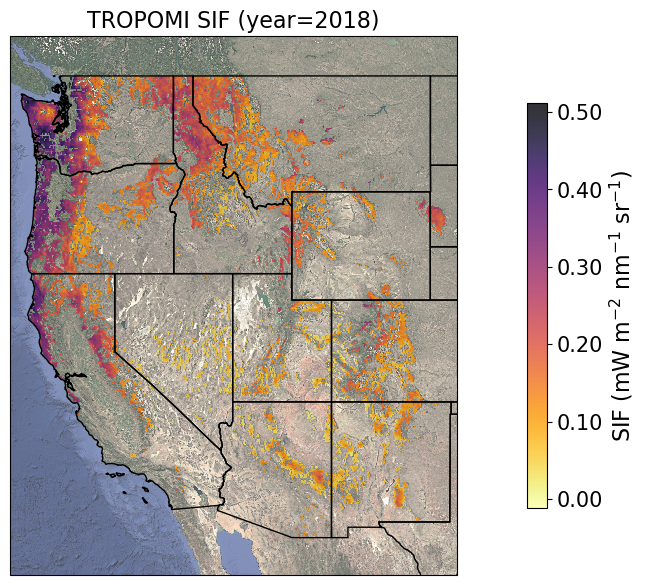

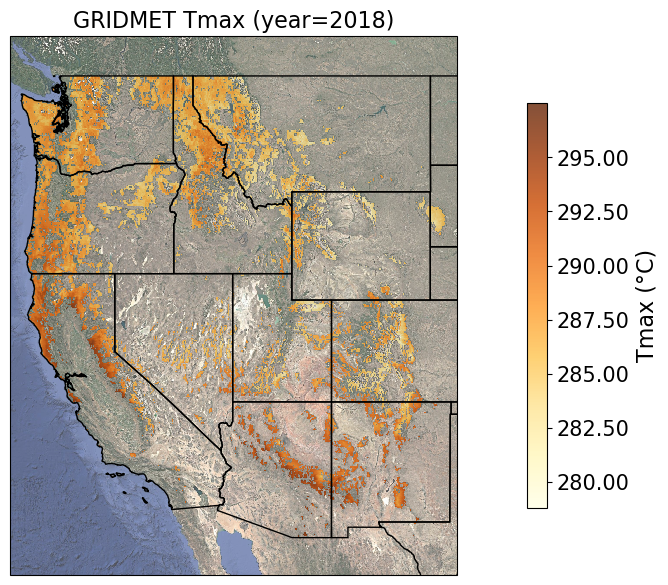

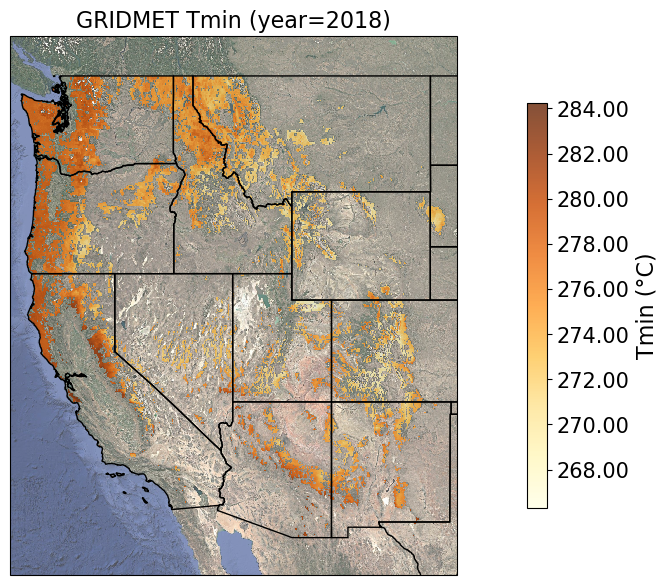

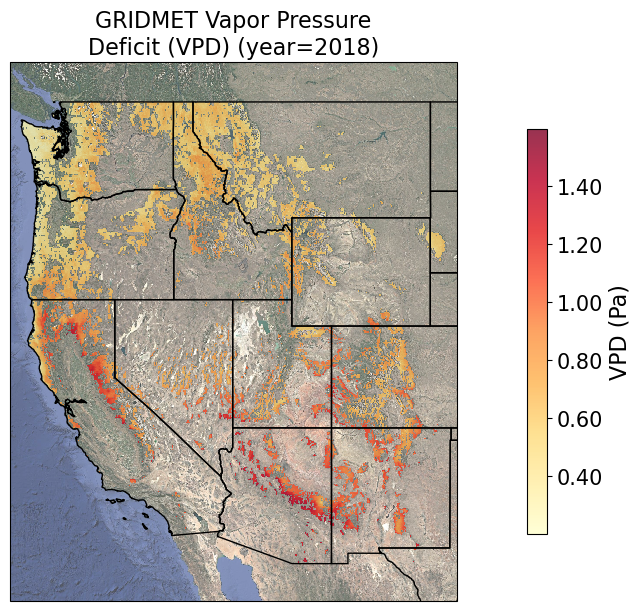

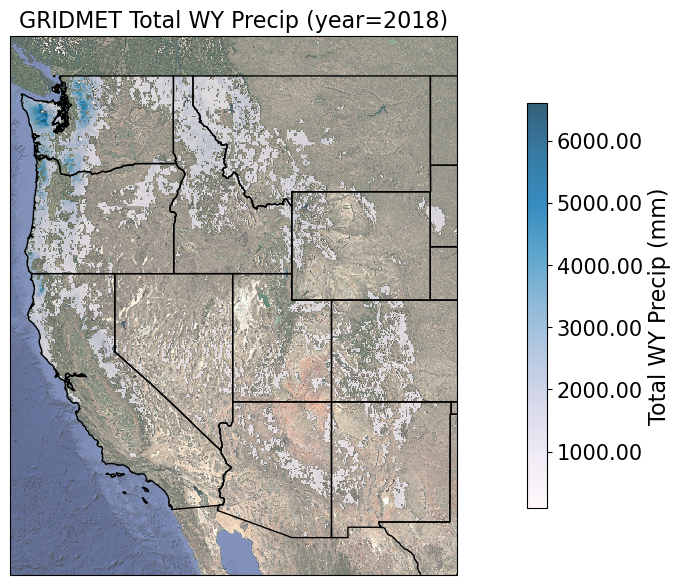

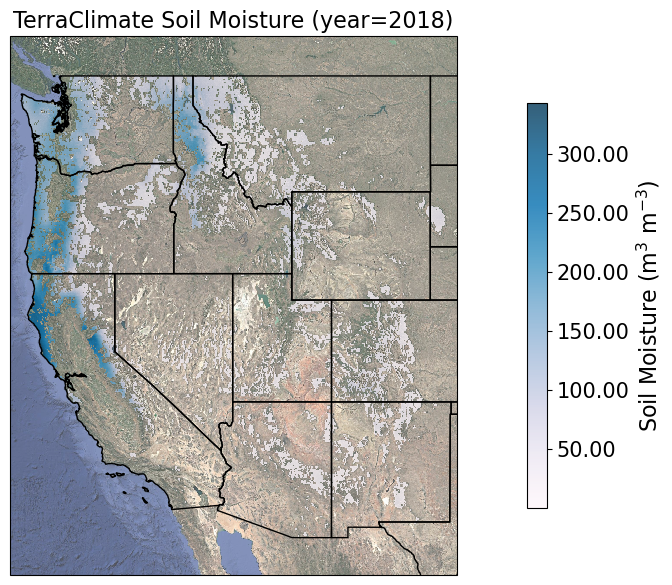

In [6]:
def plot_dataarray_map(dat_da, plotTitle, zax_label, plot_min=None, plot_max=None, cmap='inferno_r'):
    if plot_min is None:
        plot_min = np.nanmin(dat_da.values)
    if plot_max is None:
        plot_max = np.nanmax(dat_da.values)
    fig, ax = plt.subplots(subplot_kw={'projection': crs}, figsize=(9, 7)) # establish the figure, axes
    # Set extent of map before adding base img
    ax.set_extent(extent, crs=ccrs.PlateCarree())  # PlateCarree is default lat/lon
    ax.add_image(tiler, tiler_zoom, interpolation='none', alpha=0.7) # Add base image

    dat_da.plot(ax=ax, transform=transform, alpha=alpha,
                    cmap=cmap, vmin = plot_min, vmax = plot_max,
                        cbar_kwargs={'orientation': 'vertical',
                                            'pad': 0.1,
                                            'label': zax_label,
                                            'shrink': 0.75,
                                            'format': FFmt(z_axis_formatter)})

    # add state/ecoregion boundaries to the map
    ax.add_feature(states_geom, facecolor="none", edgecolor="black", linewidth=1)

    plt.title(plotTitle) # set axis title
    plt.show()


plot_dataarray_map(TROPOMI_SIF_xr.isel(year=0), 'TROPOMI SIF (year=2018)', 
    'SIF (mW m$^{-2}$ nm$^{-1}$ sr$^{-1}$)')

plot_dataarray_map(GRIDMET_Tmax_xr.isel(year=0), 'GRIDMET Tmax (year=2018)', 
    'Tmax (°C)', cmap='YlOrBr')

plot_dataarray_map(GRIDMET_Tmin_xr.isel(year=0), 'GRIDMET Tmin (year=2018)', 
    'Tmin (°C)', cmap='YlOrBr')

plot_dataarray_map(GRIDMET_VPD_xr.isel(year=0), 'GRIDMET Vapor Pressure\nDeficit (VPD) (year=2018)', 
    'VPD (Pa)', cmap='YlOrRd')

plot_dataarray_map(GRIDMET_Precip_xr.isel(year=0), 'GRIDMET Total WY Precip (year=2018)', 
    'Total WY Precip (mm)', cmap='PuBu')

plot_dataarray_map(TerraClimate_SoilM_xr.isel(year=0), 'TerraClimate Soil Moisture (year=2018)', 
    'Soil Moisture (m$^3$ m$^{-3}$)', cmap='PuBu')


### Adding geographic predictor variables

Now we will add in some of the static/geographic variables (elevation, tree canopy cover, historical mean annual precipitation) and see how much of the variability in these relationships is explained by these. First let's load and visualize these across the domain.

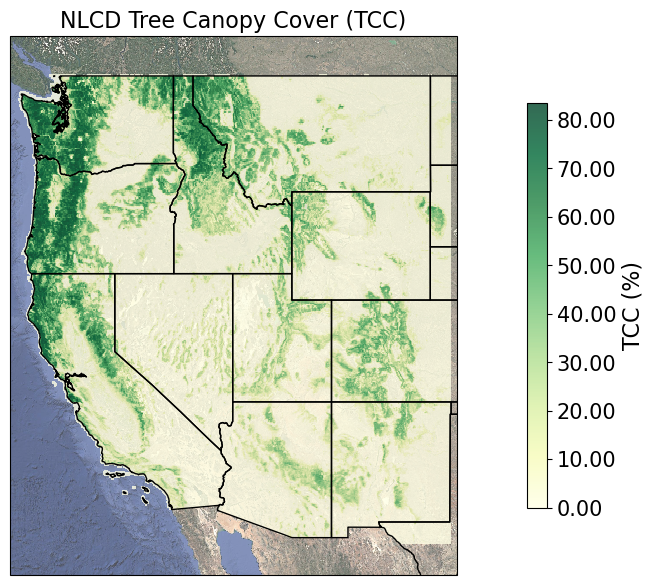

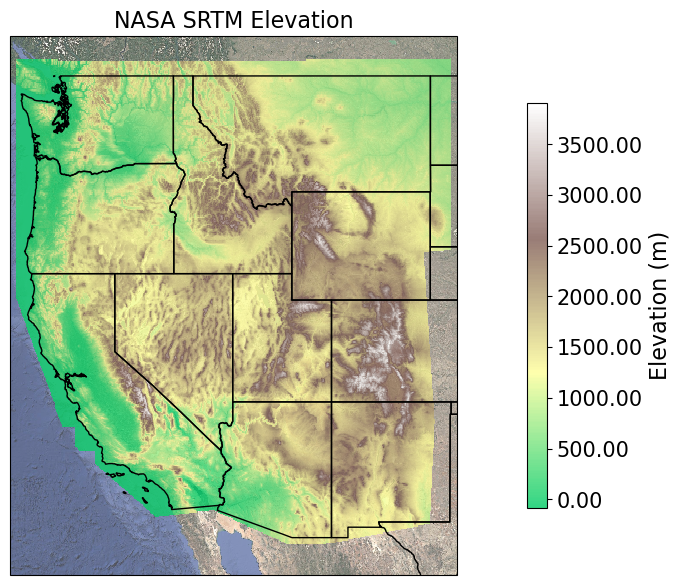

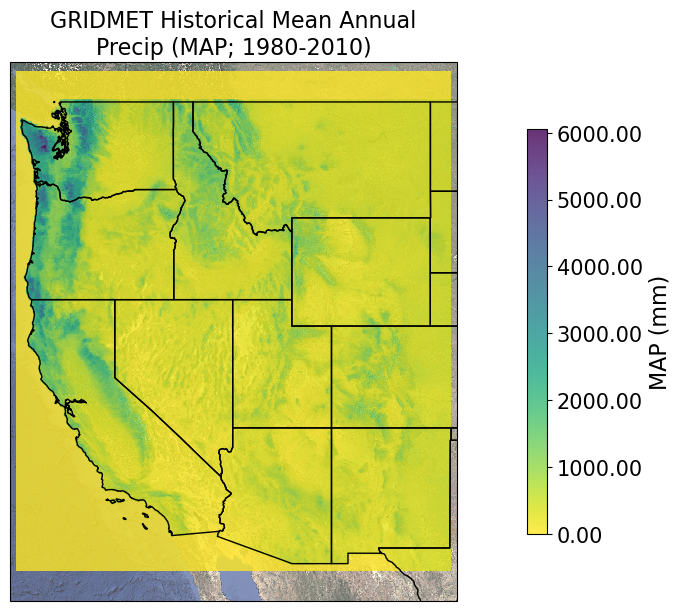

In [10]:
TCC_xr = xr.open_dataset(TCC_file, decode_coords='all').rename({'lon':'x', 'lat':'y'}).sortby(['x', 'y'], ascending = True).squeeze('band')['tree_canopy_cover'] # NLCD Tree Cover
elev_xr = xr.open_dataset(elev_file, decode_coords='all').rename({'lon':'x', 'lat':'y'}).sortby(['x', 'y'], ascending = True).squeeze('band')['elevation'] # SRTM Elevation
MAP_xr = xr.open_dataset(MAP_file, decode_coords='all').sortby(['x', 'y'], ascending = True)['mean'] # GRIDMET Mean Annual Precipitation

# Plot NLCD Tree Canopy Cover
plot_dataarray_map(TCC_xr, 'NLCD Tree Canopy Cover (TCC)', 
    'TCC (%)', cmap='YlGn')

# Plot NASA SRTM Elevation
# Custom terrain colormap for the elevation map - land only
terrain_colors = plt.cm.terrain(np.linspace(0.25, 1, 256))  # Skip the blue/water colors at the start
custom_terrain_cmap = mcolors.LinearSegmentedColormap.from_list('custom_terrain', terrain_colors)
plot_dataarray_map(elev_xr, 'NASA SRTM Elevation', 
    'Elevation (m)', cmap=custom_terrain_cmap)

# Plot GRIDMET Historical Mean Annual Precipitation
plot_dataarray_map(MAP_xr, 'GRIDMET Historical Mean Annual\nPrecip (MAP; 1980-2010)', 
    'MAP (mm)', cmap='viridis_r')

### Simple regression and Semivariogram analyses

For each regression, we will calculate the semivariogram from the residuals
This will show us roughly at what euclidean distances the pixel pairs' residuals are correlated, and at what distances they are not correlated. The semivariogram plots below will also show a horizontal dashed line representing the overall variance of the residuals. This is shown for reference as a potential way to estimate the threshold distance where variance between pairs is similar to that of the full set of residuals.



Modeling variable: Tmax


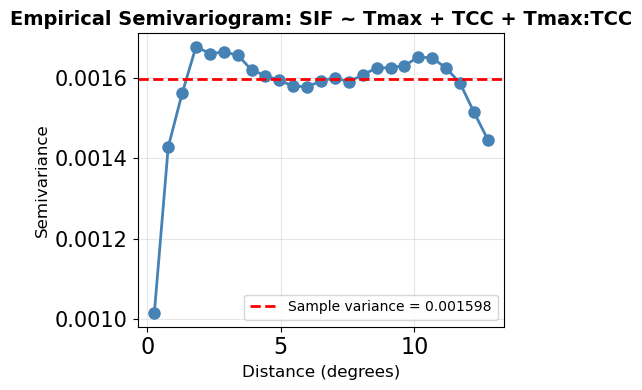


Modeling variable: Tmin


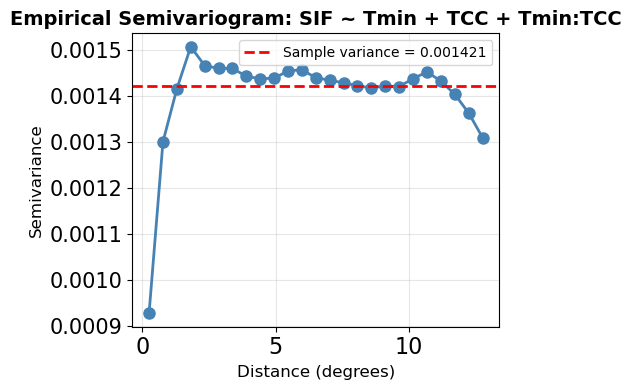


Modeling variable: VPD


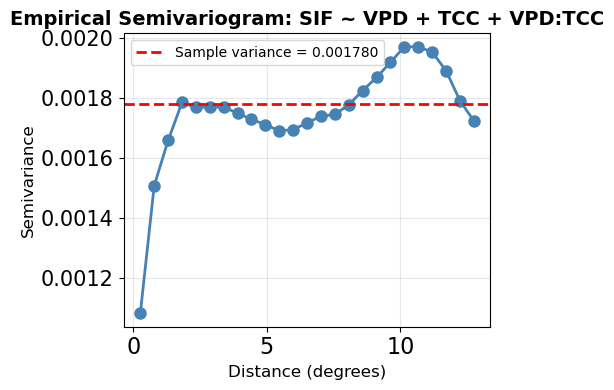


Modeling variable: Precip


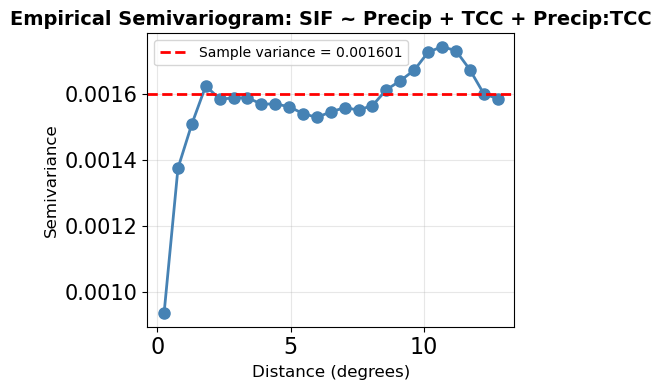


Modeling variable: SoilM


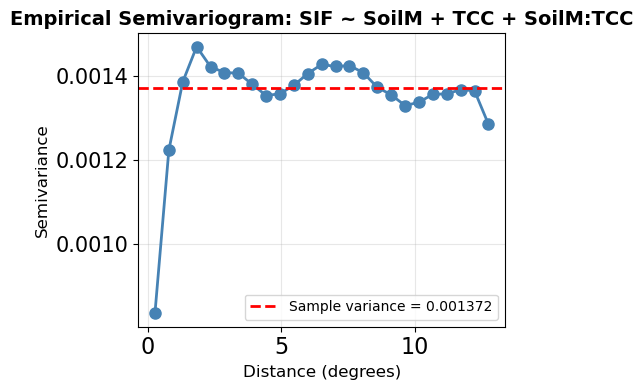


Modeling variable: Tmax


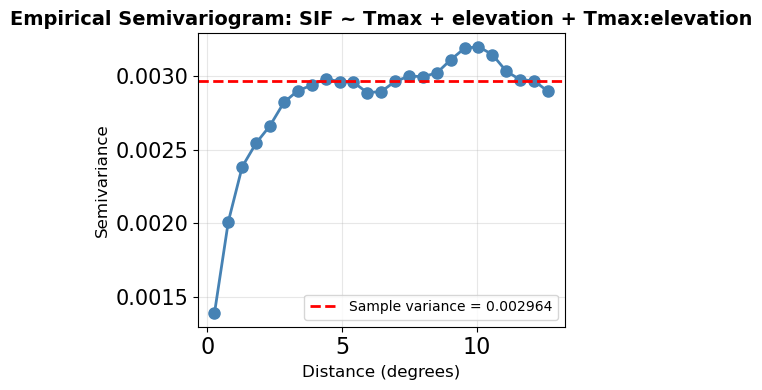


Modeling variable: Tmin


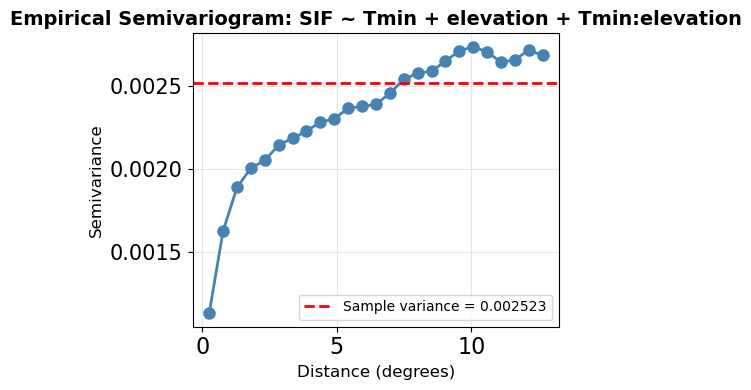


Modeling variable: VPD


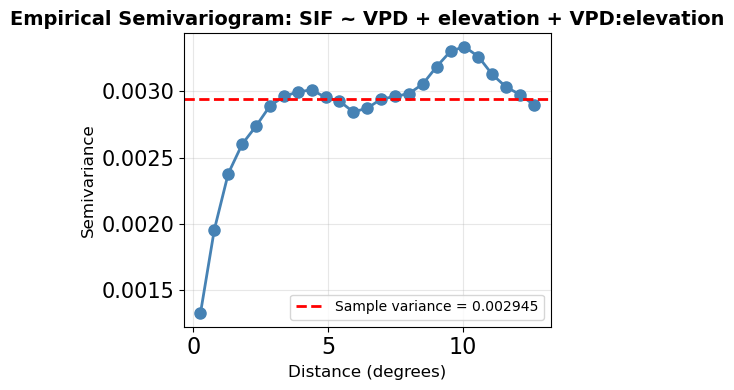


Modeling variable: Precip


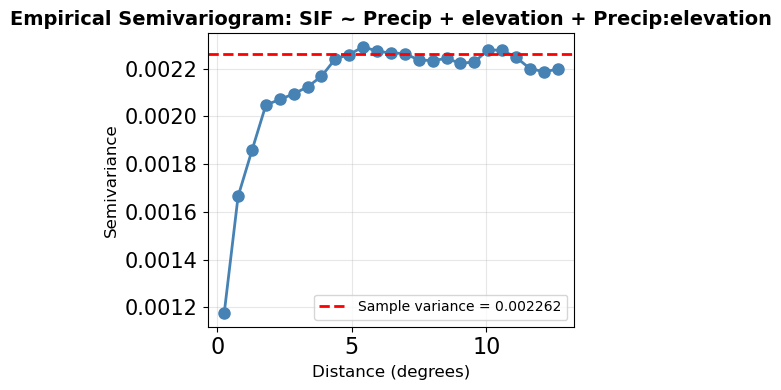


Modeling variable: SoilM


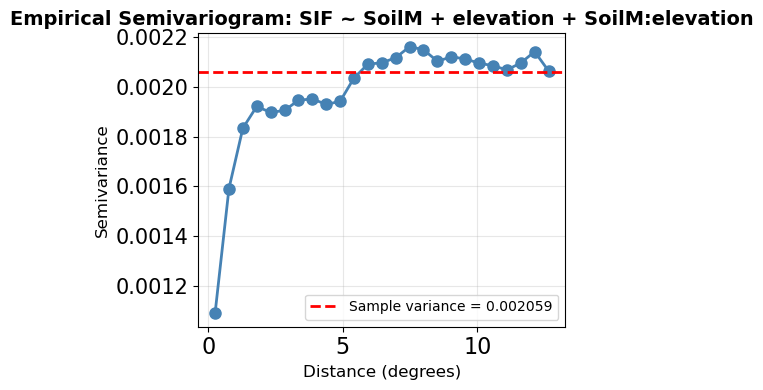


Modeling variable: Tmax


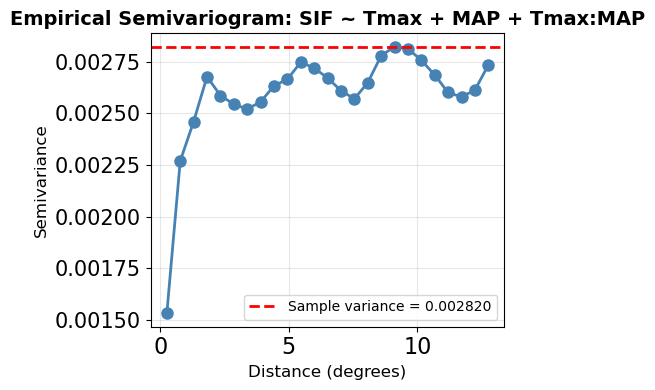


Modeling variable: Tmin


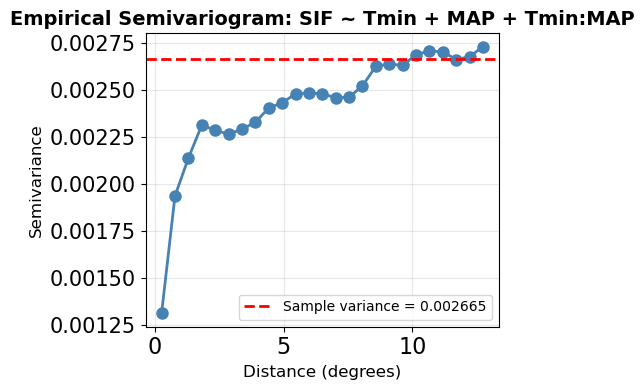


Modeling variable: VPD


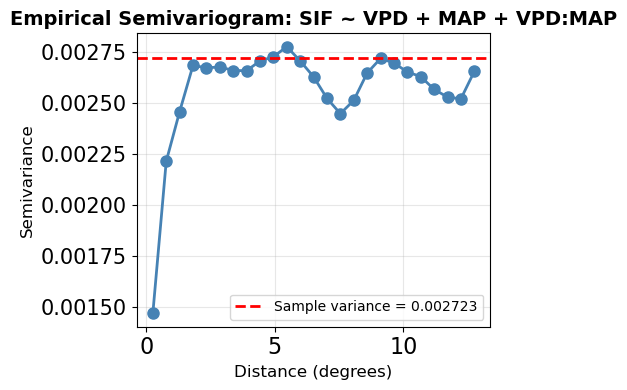


Modeling variable: Precip


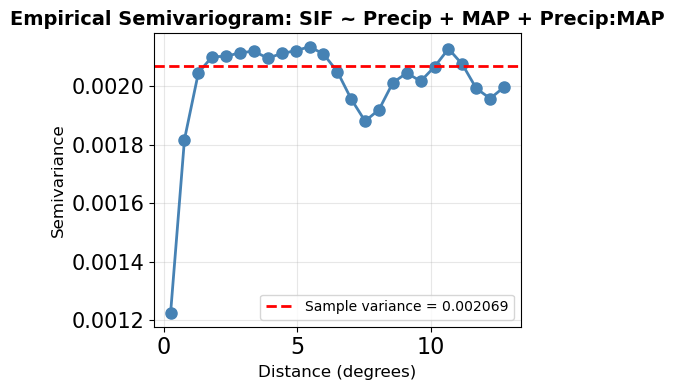


Modeling variable: SoilM


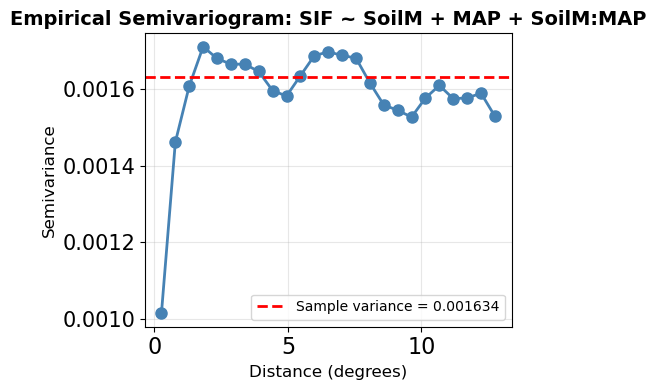

In [15]:
# Create an array of the xarray variables to test as covariates
covariates_descr = 'climate'
covariate_xr_arr = [GRIDMET_Tmax_xr, GRIDMET_Tmin_xr, GRIDMET_VPD_xr, GRIDMET_Precip_xr, TerraClimate_SoilM_xr]
covariate_names = ['Tmax', 'Tmin', 'VPD', 'Precip', 'SoilM']

geo_vars_xr = [TCC_xr, elev_xr, MAP_xr]
geo_var_names = ['TCC', 'elevation', 'MAP']

for geo_xr, geo_name in zip(geo_vars_xr, geo_var_names):
    covariate_results = {}
    for covariate_xr, covariate_name in zip(covariate_xr_arr, covariate_names):

        print(f"\nModeling variable: {covariate_name}")
        model_results = {}
        xr_data_dict = {
            'SIF': TROPOMI_SIF_xr,
            covariate_name: covariate_xr,
            geo_name: geo_xr,
        }

        df_long = xarray_to_long_df(xr_data_dict, 'SIF')
        key_vars = ['SIF', covariate_name, geo_name]

        # Add pixel_id, longitude, latitude
        df_long['pixel_id'] = df_long['x'].astype(str) + '_' + df_long['y'].astype(str)
        df_long['longitude'] = df_long['x']
        df_long['latitude'] = df_long['y']

        # Clean up - remove rows with missing values in key variables
        df_model = df_long.dropna(subset=key_vars).copy()

        # Standardize predictors
        all_predictors = [covariate_name, geo_name]
        df_standardized = df_model.copy()
        df_standardized[all_predictors] = StandardScaler().fit_transform(df_model[all_predictors])

        # Fit multilinear regression model
        formula = f'SIF ~ {covariate_name} + {geo_name} + {covariate_name}:{geo_name}'
        try:
            model = smf.ols(formula, data=df_standardized)
            result = model.fit()
        except Exception as e:
            print(f"Model fitting failed: {e}")

        # Get residuals from the model
        residuals = result.resid

        # Create DataFrame with residuals and spatial info
        resid_df = df_standardized[['pixel_id', 'x', 'y', 'year']].copy()
        resid_df['residual'] = residuals.values

        # Get pixel-level mean residuals (averaged across years)
        pixel_resid = resid_df.groupby('pixel_id').agg({
            'x': 'first',
            'y': 'first', 
            'residual': 'mean'
        }).reset_index()

        # Extract coordinates
        coords = pixel_resid[['x', 'y']].values

        # Calculate Euclidean distances (in degrees)
        # For more accurate distances, you could convert to meters using geopy
        distances = pdist(coords, metric='euclidean')

        # Convert to square matrix for easier indexing
        distance_matrix = squareform(distances)

        # Calculate empirical variogram
        # Limit to reasonable max distance (e.g., half the max distance)
        max_dist = distance_matrix.max() / 2

        bin_centers, semivariance, pair_counts = calculate_semivariogram(
            pixel_resid['residual'].values,
            distances,
            n_bins=25,
            max_distance=max_dist
        )

        # Filter out bins with too few pairs
        min_pairs = 30
        valid_bins = pair_counts >= min_pairs

        #########################################
        # Plot empirical variogram
        #########################################
        fig, ax = plt.subplots(figsize=(5, 4))

        # Plot 1: Semivariogram
        ax.plot(bin_centers[valid_bins], semivariance[valid_bins], 
                'o-', markersize=8, linewidth=2, color='steelblue')
        ax.axhline(y=pixel_resid['residual'].var(), 
                    color='red', linestyle='--', linewidth=2,
                    label=f'Sample variance = {pixel_resid["residual"].var():.6f}')
        ax.set_xlabel('Distance (degrees)', fontsize=12)
        ax.set_ylabel('Semivariance', fontsize=12)
        ax.set_title(f'Empirical Semivariogram: SIF ~ {covariate_name} + {geo_name} + {covariate_name}:{geo_name}', fontsize=14, fontweight='bold')
        ax.grid(alpha=0.3)
        ax.legend(fontsize=10)
        plt.tight_layout()
        plt.show()

